In [23]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# Preprocess the input images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img


In [25]:
# Deprocess the output image for display
def deprocess_image(image):
    img = image.reshape((224, 224, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [26]:
# Get the VGG19 model with selective layers trainable
def get_vgg_model():
    vgg = VGG19(weights='imagenet', include_top=False)
    for layer in vgg.layers:
        if 'block5' in layer.name:  # Fine-tune only the last block
            layer.trainable = True
        else:
            layer.trainable = False
    return vgg

In [27]:
# Create a feature model to extract content and style features
def get_feature_model(vgg, content_layer, style_layers):
    outputs = [vgg.get_layer(name).output for name in style_layers + [content_layer]]
    model = Model([vgg.input], outputs)
    return model

In [28]:
# Compute content loss
def content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

In [29]:
# Compute the Gram matrix for style loss
def gram_matrix(tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    input_shape = tf.shape(tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations


In [30]:
# Compute style loss
def style_loss(style, generated):
    S = gram_matrix(style)
    G = gram_matrix(generated)
    return tf.reduce_mean(tf.square(S - G))


In [31]:
# Compute the total variation loss for smoothing
def total_variation_loss(image):
    x_deltas = image[:, 1:, :, :] - image[:, :-1, :, :]
    y_deltas = image[:, :, 1:, :] - image[:, :, :-1, :]
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))


In [32]:
# Compute total loss
def compute_loss(model, generated_image, content_output, style_outputs):
    model_outputs = model(generated_image)
    generated_style_outputs = model_outputs[:-1]
    generated_content_output = model_outputs[-1]

    c_loss = content_loss(content_output, generated_content_output)
    s_loss = 0
    for generated_style_output, style_output in zip(generated_style_outputs, style_outputs):
        s_loss += style_loss(style_output, generated_style_output)

    # Add total variation loss
    tv_loss = total_variation_loss(generated_image)

    total_loss = content_weight * c_loss + style_weight * s_loss + tv_weight * tv_loss
    return total_loss

In [33]:
# Optimizer
opt = tf.optimizers.Adam(learning_rate=0.000001)  # Lowered learning rate

# Training step
@tf.function
def train_step(generated_image, content_output, style_outputs, model):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, generated_image, content_output, style_outputs)
    grad = tape.gradient(loss, generated_image)

    # Apply gradient clipping without iterating over the gradients
    clipped_grad = tf.clip_by_value(grad, -5.0, 5.0)

    opt.apply_gradients([(clipped_grad, generated_image)])
    return loss


Loading....


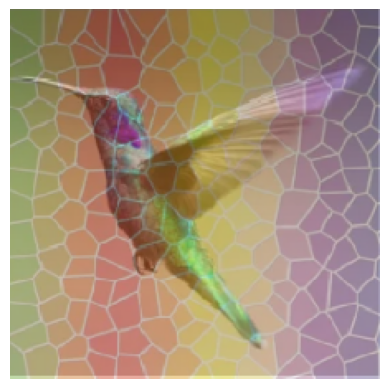

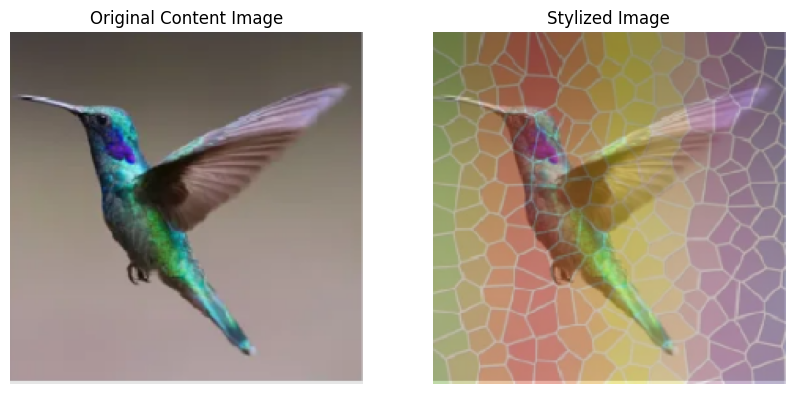

In [34]:
# Fine-tuning function
def fine_tune_style_transfer(content_image_path, style_image_path, epochs=10):
    content_image = preprocess_image(content_image_path)
    style_image = preprocess_image(style_image_path)

    vgg = get_vgg_model()
    content_layer = 'block4_conv2'
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

    feature_model = get_feature_model(vgg, content_layer, style_layers)
    style_outputs = feature_model(style_image)[:-1]
    content_output = feature_model(content_image)[-1]

    # Initialize generated image
    generated_image = tf.Variable(preprocess_image(content_image_path) * 0.6 + preprocess_image(style_image_path) * 0.4)

    for epoch in range(epochs):
        loss = train_step(generated_image, content_output, style_outputs, feature_model)

        if epoch % 100 == 0:
            print(f'Loading....')
            img = deprocess_image(generated_image.numpy())
            plt.imshow(img)
            plt.axis('off')  # Hide axis
            plt.show()

    final_image = deprocess_image(generated_image.numpy())

    # Save the model after training
    feature_model.save('style_transfer_model.h5')
    return final_image

# Adjusting the content, style, and total variation weights
content_weight = 1e2  # Reduced content weight
style_weight = 1e-2   # Increased style weight
tv_weight = 1e-4      # Total variation weight

content_image_path = '/content/content1.PNG'
style_image_path = '/content/style1.PNG'

# Running the fine-tuning with 1000 epochs
final_img = fine_tune_style_transfer(content_image_path, style_image_path, epochs=10)

# Load the original content image for display
original_content_img = deprocess_image(preprocess_image(content_image_path))

# Display the original content image and the final stylized image side by side
plt.figure(figsize=(10, 5))

# Original Content Image
plt.subplot(1, 2, 1)
plt.imshow(original_content_img)
plt.title('Original Content Image')
plt.axis('off')  # Hide axis

# Final Stylized Image
plt.subplot(1, 2, 2)
plt.imshow(final_img)
plt.title('Stylized Image')
plt.axis('off')  # Hide axis

plt.show()


In [35]:
model = load_model('style_transfer_model.h5')

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,944,960 (49.38 MB)

 Trainable params: 2,359,808 (9.00 MB)

 Non-trainable params: 10,585,152 (40.38 MB)